In [24]:
import re
import os

import pandas as pd
import numpy as np
import string
from collections import Counter
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
files.upload()

In [4]:
!pip install -q kaggle

In [5]:
!mkdir -p ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 /root/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d vkrahul/twitter-hate-speech

  0% 0.00/1.89M [00:00<?, ?B/s]
100% 1.89M/1.89M [00:00<00:00, 62.3MB/s]


In [10]:
!unzip /content/twitter-hate-speech.zip

Archive:  /content/twitter-hate-speech.zip
  inflating: test_tweets_anuFYb8.csv  
  inflating: train_E6oV3lV.csv       


In [12]:
raw_data = pd.read_csv('/content/train_tweets.csv')
data = raw_data.copy()
data.drop(columns=['id'], axis=1, inplace=True)
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [17]:
print(np.round(data['label'].value_counts()[0]/len(data) * 100, 2), "% are Normal Speech")
print(np.round(data['label'].value_counts()[1]/len(data) * 100, 2), "% are Hate Speech")

92.99 % are Normal Speech
7.01 % are Hate Speech


Text(0.5, 1.0, 'Class Distributions \n 0: Normal      1: Hate')

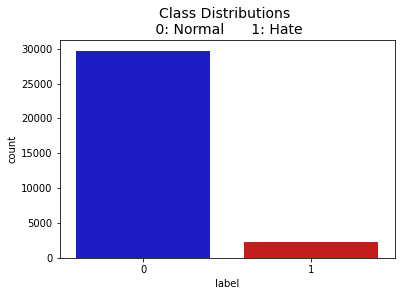

In [22]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('label', data=data, palette=colors)
plt.title('Class Distributions \n 0: Normal      1: Hate', fontsize=14)

In [32]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F" #emoticons
                u"\U0001F300-\U0001F5FF" #symbols & pictograms
                u"\U0001F680-\U0001F6FF" #transport & map symbols
                u"\U0001F1E0-\U0001F1FF" #flags(ios)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251" 
                "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(text):
    delete_dict = {sp_character: '' for sp_character in string.punctuation}
    delete_dict[' '] = ' '
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr = text1.split()
    text2 = ' '.join([w for w in textArr if(not w.isdigit() and (not w.isdigit() and len(w) > 3))])

    return text2.lower()

In [35]:
smptw = '@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why'
smptw = remove_emoji(smptw)
smptw = clean_text(smptw)
print(smptw)

user white supremacists want everyone birdsâ movie hereâs


In [36]:
data['tweet'] = data['tweet'].apply(remove_emoji)
data['tweet'] = data['tweet'].apply(clean_text)
data['num_words_text'] = data['tweet'].apply(lambda x : len(str(x).split()))

train_data, val_data = train_test_split(data, test_size=0.2)
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

In [38]:
test_data = val_data
print("==== Train Data ====")
print(train_data['label'].value_counts())
print(len(train_data))

print("==== Test Data ====")
print(test_data['label'].value_counts())
print(len(test_data))

==== Train Data ====
0    23784
1     1785
Name: label, dtype: int64
25569
==== Test Data ====
0    5936
1     457
Name: label, dtype: int64
6393


In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['tweet'].tolist(), train_data['label'].tolist(), test_size=0.2, stratify=train_data['label'].tolist(), random_state=0)
print("Train Data len: ", len(X_train))
print("Class distribution: ", Counter(y_train))
print("Validation Data len: ", len(X_valid))
print("Class distribution: ", Counter(y_valid))

Train Data len:  20455
Class distribution:  Counter({0: 19027, 1: 1428})
Validation Data len:  5114
Class distribution:  Counter({0: 4757, 1: 357})


In [42]:
X_train[5]

'user couple knew thatll together forever just broke upð\x9f\x92\x94ð\x9f\x98\x9eð\x9f\x98\x94 dilmer'

In [43]:
num_words=50000

tokenizer = Tokenizer(num_words=num_words, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train)

In [45]:
x_train = np.array(tokenizer.texts_to_sequences(X_train))
x_valid = np.array(tokenizer.texts_to_sequences(X_valid))
x_test = np.array(tokenizer.texts_to_sequences(test_data['tweet'].tolist()))

maxlen=50
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_valid = pad_sequences(x_valid, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

train_labels = np.asarray(y_train)
valid_labels = np.asarray(y_valid)
test_labels = np.asarray(test_data['label'].tolist())

print("Train data: ", len(x_train))
print("Validation data: ", len(x_valid))
print("Test data: ", len(x_test))

#Tensorflow dataset
train_ds = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, test_labels))

Train data:  20455
Validation data:  5114
Test data:  6393


In [47]:
max_features = 50000
embedding_dim = 16
sequence_length=maxlen

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features + 1, embedding_dim, input_length=sequence_length, embeddings_regularizer=regularizers.l2(0.005)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.LSTM(embedding_dim, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=regularizers.l2(0.005), bias_regularizer=regularizers.l2(0.005)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            800016    
_________________________________________________________________
dropout (Dropout)            (None, 50, 16)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 50, 16)            2112      
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               410112    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                

In [48]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-3), metrics=[tf.keras.metrics.BinaryAccuracy()])

In [49]:
epochs=100
history=model.fit(train_ds.shuffle(5000).batch(1024), epochs=epochs, validation_data=valid_ds.batch(1024), verbose=1)

Epoch 1/100
20/20 [==============================] - 10s 305ms/step - loss: 3.8426 - binary_accuracy: 0.8469 - val_loss: 1.5764 - val_binary_accuracy: 0.9302
Epoch 2/100
20/20 [==============================] - 6s 287ms/step - loss: 1.3267 - binary_accuracy: 0.9293 - val_loss: 0.6721 - val_binary_accuracy: 0.9302
Epoch 3/100
20/20 [==============================] - 6s 278ms/step - loss: 0.6547 - binary_accuracy: 0.9300 - val_loss: 0.4740 - val_binary_accuracy: 0.9302
Epoch 4/100
20/20 [==============================] - 5s 273ms/step - loss: 0.4983 - binary_accuracy: 0.9303 - val_loss: 0.4181 - val_binary_accuracy: 0.9302
Epoch 5/100
20/20 [==============================] - 6s 276ms/step - loss: 0.4537 - binary_accuracy: 0.9309 - val_loss: 0.3912 - val_binary_accuracy: 0.9302
Epoch 6/100
20/20 [==============================] - 6s 281ms/step - loss: 0.4314 - binary_accuracy: 0.9293 - val_loss: 0.3725 - val_binary_accuracy: 0.9302
Epoch 7/100
20/20 [==============================] - 6s 2

In [50]:
predictions = model.predict(x_test)
print(predictions)

[[7.0840586e-05]
 [1.4306902e-06]
 [1.1695610e-06]
 ...
 [1.3989152e-06]
 [8.9077048e-07]
 [6.8215045e-06]]


In [61]:
def display_training_curves(training, validation, title, subplot):
    _, ax = plt.subplots(figsize=(10,5), facecolor='#F0F0F0')
    plt.tight_layout()
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epochs')
    ax.legend(['train', 'valid.'])

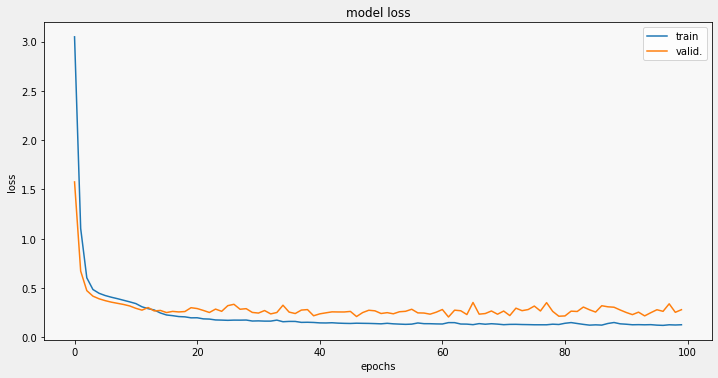

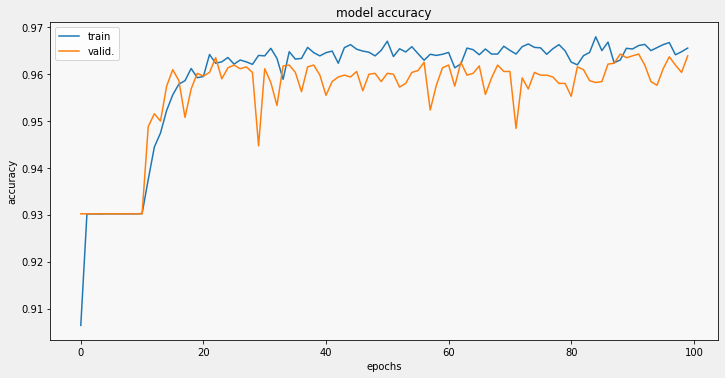

In [62]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss', 211)
display_training_curves(
    history.history['binary_accuracy'], 
    history.history['val_binary_accuracy'], 
    'accuracy', 212)

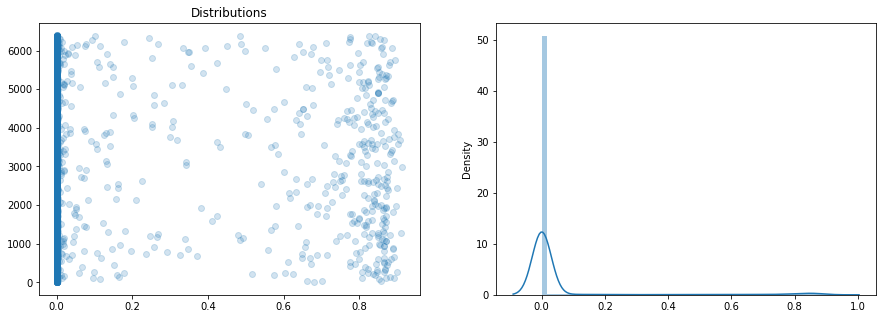

In [66]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.scatter(predictions, range(0, len(predictions)), alpha=0.2)
ax1.set_title("Distributions")
ax2 = sns.distplot(predictions)

In [68]:
final_test_df = pd.read_csv('test_tweets.csv')
ftest = final_test_df.copy()
ftest.drop(columns=['id'], axis=1, inplace=True)

ftest['tweet'] = ftest['tweet'].apply(remove_emoji)
ftest['tweet'] = ftest['tweet'].apply(clean_text)

f_test = np.array(tokenizer.texts_to_sequences(ftest['tweet'].tolist()))
f_test = pad_sequences(f_test, padding='post', maxlen=maxlen)

display(f_test)

array([[25732,     1,  9182, ...,     0,     0,     0],
       [    2,   185, 20821, ...,     0,     0,     0],
       [  458,   718,   602, ...,     0,     0,     0],
       ...,
       [  580,     1,    18, ...,     0,     0,     0],
       [    7,    36,   318, ...,     0,     0,     0],
       [  296,   565,   127, ...,     0,     0,     0]], dtype=int32)

In [69]:
predictions_f_test = model.predict(f_test)

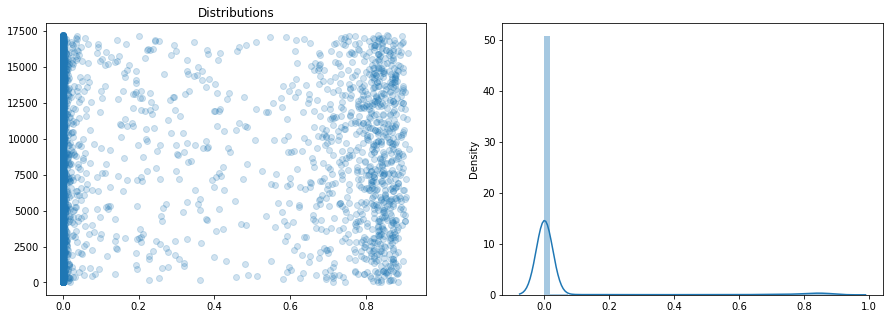

In [71]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.scatter(predictions_f_test, ftest.index, alpha=0.2)
ax1.set_title("Distributions")
ax2 = sns.distplot(predictions_f_test)

In [73]:
!pip3 freeze > requirements.txt